In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# SETUP
!pip -q install diffusers==0.30.0 transformers accelerate xformers opencv-python==4.10.0.84 einops
!pip -q install kornia basicsr

from diffusers import DiffusionPipeline, AutoPipelineForImage2Image, ControlNetModel, StableDiffusionXLControlNetImg2ImgPipeline, StableDiffusionControlNetImg2ImgPipeline
from diffusers.utils import load_image
import torch, cv2, numpy as np, os
from PIL import Image, ImageOps

device = "cuda" if torch.cuda.is_available() else "cpu"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.4/299.4 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 107.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 24.7 MB/s eta 0:00:00


In [ ]:
#PATHS
inputImg  = "/content/drive/MyDrive/training_data/ControlNet_Canny_V0_test/015_8_8_8_out.png"
outputFolder = "/content/drive/MyDrive/outputs/v6_sat2uav/v2"
os.makedirs(outputFolder, exist_ok=True)

In [ ]:
# PROMPTS
posPrompt = ("nadir UAV aerial photo, urban street scene, photorealistic textures, "
              "crisp asphalt grain, realistic concrete and dirt, detailed grass blades, "
              "metal roof panels, high detail")
negPrompt = ("painting, cartoon, over-sharpened halos, watercolor, mosaic, repeated patterns, "
              "warped lines, inaccurate perspective, low-detail")



In [ ]:
# PREP STUFF: loading & normalising
img = Image.open(inputImg).convert("RGB")
longEdge = max(img.size)
target = 1536 if longEdge <= 1536 else min(2048, longEdge)
img = ImageOps.exif_transpose(img)
img = img.resize((target, target), Image.LANCZOS) if img.size[0]!=img.size[1] else img.resize((target, target), Image.LANCZOS)

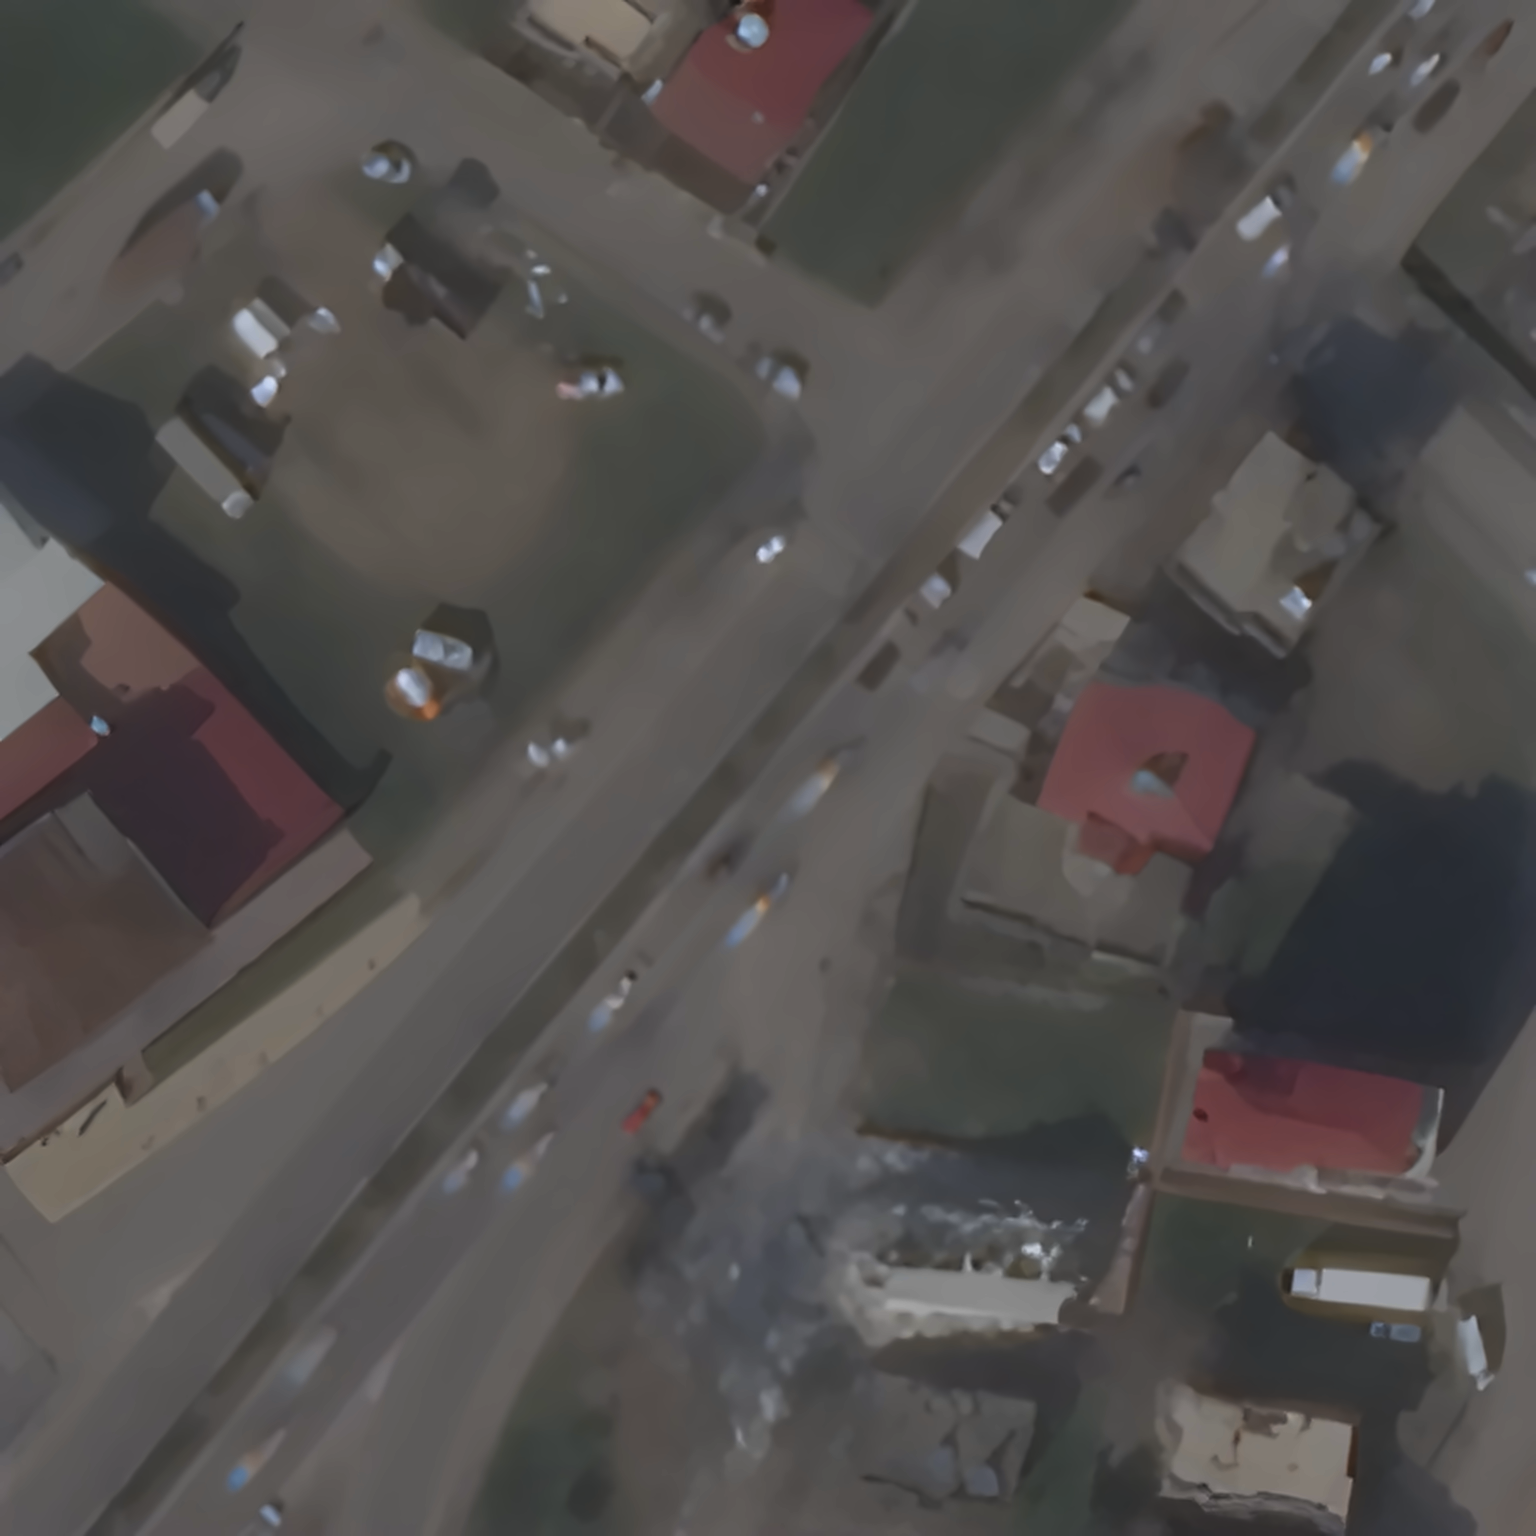

In [ ]:
# mild denoiseing to attempt removeing some SR blurriness
npImg = np.array(img)
npImg = cv2.fastNlMeansDenoisingColored(npImg, None, 3, 3, 7, 21)
img = Image.fromarray(npImg)
display(img)

/usr/local/lib/python3.12/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip


/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(


Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_hybrid_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_hybrid_384.pt


100%|██████████| 470M/470M [00:06<00:00, 77.1MB/s]
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


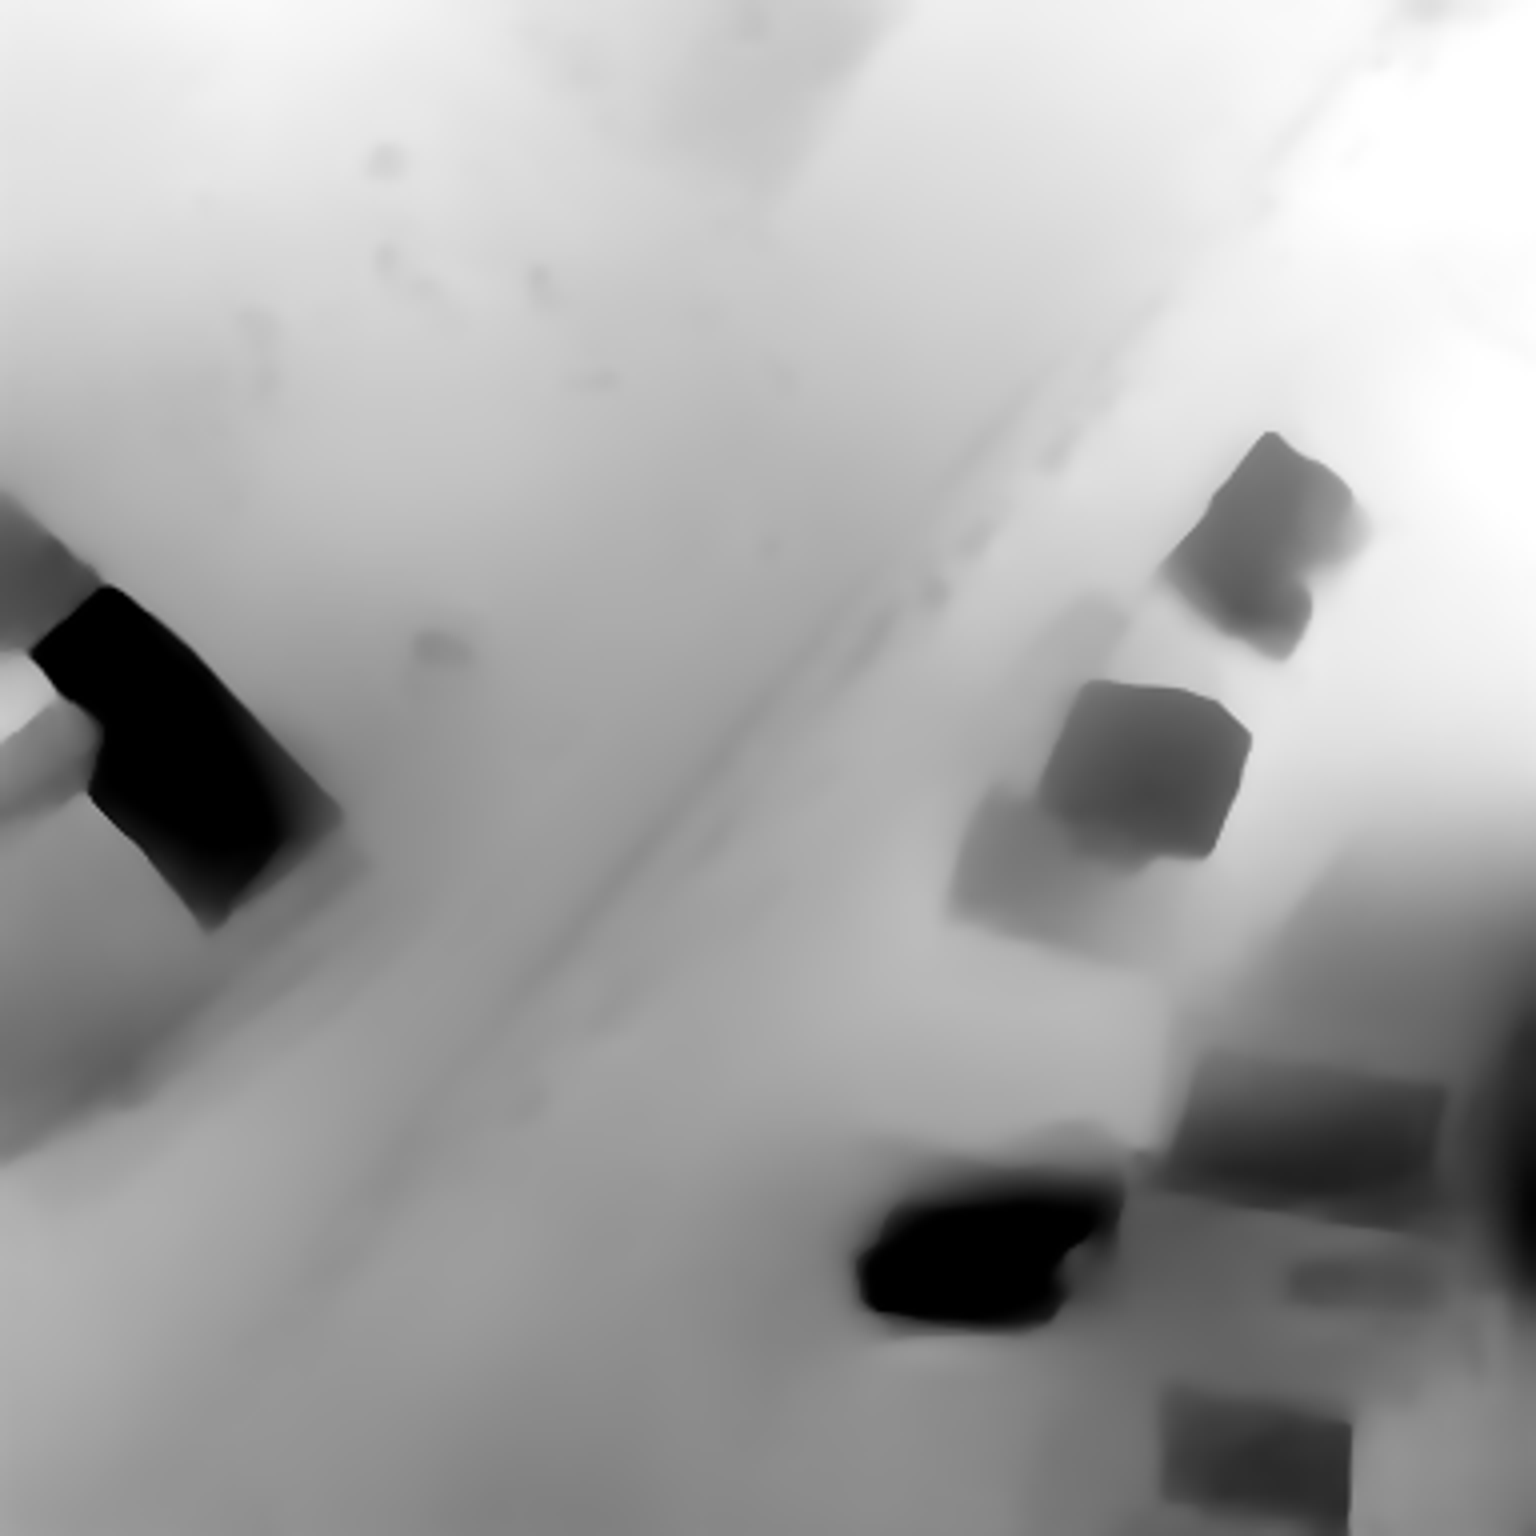

In [ ]:
#Depth map
!pip -q install opencv-python timm
import torch, cv2, numpy as np
from PIL import Image

# MiDaS/DPT-Hybrid
midas = torch.hub.load("intel-isl/MiDaS", "DPT_Hybrid").eval().to("cuda")
midasTransforms = torch.hub.load("intel-isl/MiDaS", "transforms")
tfm = midasTransforms.dpt_transform

import numpy as np, cv2, torch
from PIL import Image

@torch.no_grad()
def infer_depth_pil(pilImg: Image.Image) -> Image.Image:
    arr = np.array(pilImg)  # RGB HxWx3, uint8

    input_t = tfm(arr).to("cuda")

    depth = midas(input_t).squeeze().float().cpu().numpy()  # HxW float32

    ## Basic version
    # normalise and invert
    # d = (depth - depth.min()) / (depth.max() - depth.min() + 1e-8)
    # inv = 1.0 - d
    # inv = (inv * 255.0).astype(np.uint8)

    # Better version for more 2d-like images ignoring global min/max so imaegs with low range show better variation
    pmin, pmax = np.percentile(depth, (2, 98))
    d = np.clip((depth - pmin) / (pmax - pmin + 1e-8), 0, 1)
    inv = 1.0 - d
    inv = (inv * 255).astype(np.uint8)

    # helps remove banding
    inv = cv2.bilateralFilter(inv, 5, 12, 12)

    # ControlNet-Depth; stack to RGB
    depthRGB = cv2.cvtColor(inv, cv2.COLOR_GRAY2RGB)
    return Image.fromarray(depthRGB)

#resizing back to og after depth map reduction + displaying
w, h = img.size
depthPil = infer_depth_pil(img)
depthPil = depthPil.resize((w, h), Image.BICUBIC)
display(depthPil)

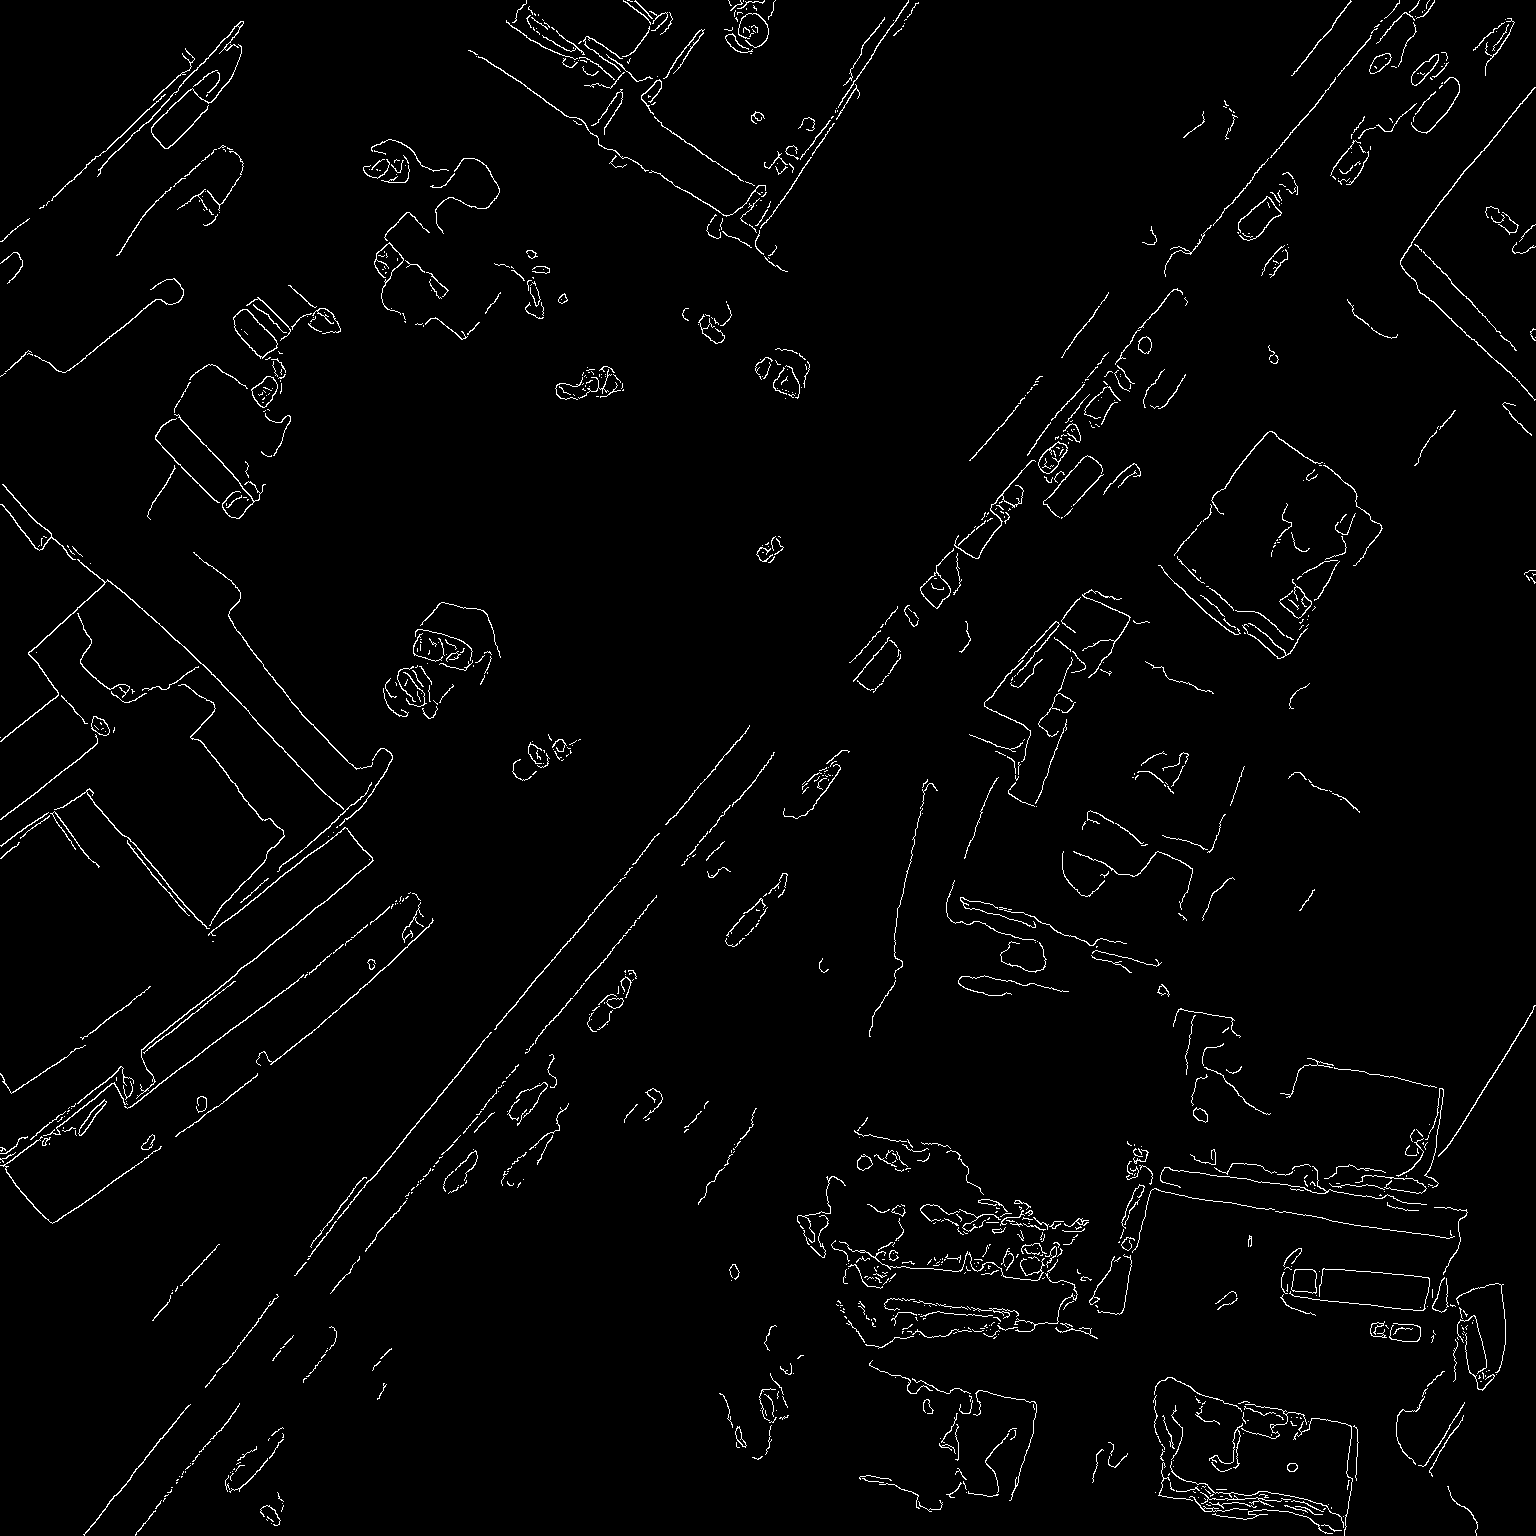

In [ ]:
# Generating Canny edge map
gray = cv2.cvtColor(npImg, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 25, 50)
edgesRGB = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
edgesPil = Image.fromarray(edgesRGB)
display(edgesPil)

In [ ]:
# --- Load ControlNets (Tile + Canny) for SDXL
# conNetTilePath = "lllyasviel/control_v11p_sd15_tile"
# conNetTilePath = "diffusers/controlnet-tile-sdxl-1.0"
conNetTilePath = "xinsir/controlnet-tile-sdxl-1.0"

# conNetCannyPath = "lllyasviel/control_v11p_sd15_canny"
# conNetCannyPath = "diffusers/controlnet-canny-sdxl-1.0"
conNetCannyPath = "xinsir/controlnet-canny-sdxl-1.0"

conNetDepthPath = "xinsir/controlnet-depth-sdxl-1.0"

basePath = "stabilityai/stable-diffusion-xl-base-1.0"
# basePath = "runwayml/stable-diffusion-v1-5"

cn_tile  = ControlNetModel.from_pretrained(
    conNetTilePath, torch_dtype=torch.float16
)
cn_canny = ControlNetModel.from_pretrained(
    conNetCannyPath, torch_dtype=torch.float16
)
cn_depth = ControlNetModel.from_pretrained(
    conNetDepthPath, torch_dtype=torch.float16
)

## Old pipeline ##
# pipe = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
#     base_path,
#     controlnet=[cn_tile, cn_canny],
#     torch_dtype=torch.float16,
#     variant="fp16",
# ).to(device)

## New SDXL PIPe
pipe = StableDiffusionXLControlNetImg2ImgPipeline.from_pretrained(
    basePath,
    controlnet=[cn_tile, cn_canny, cn_depth],
    torch_dtype=torch.float16,
    variant="fp16",
).to(device)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
# Speed/quality toggles
pipe.enable_model_cpu_offload() if device!="cuda" else pipe.enable_xformers_memory_efficient_attention()

# Tiled VAE for potential seams with big sized imaeges
try:
    pipe.vae.enable_tiling()
except:
    pass

In [ ]:
### inference with Tile, Canny and Depth - gradual change###
seed = 1337
g = torch.Generator(device=device).manual_seed(seed)

controlScales = [0.01, 0.8, 0.30]

# below fades the scales - parametre tuning helpful
controlStart = [0.0, 0.0, 0.0]
controlEnd   = [0.4, 0.6, 0.9]

w, h = img.size
result = pipe(
    prompt=posPrompt,
    negative_prompt=negPrompt,
    image=img,
    control_image=[img, edgesPil, depthPil],
    controlnet_conditioning_scale=controlScales,
    control_guidance_start=controlStart,
    control_guidance_end=controlEnd,
    strength=0.50,
    guidance_scale=3.0,
    num_inference_steps=50,
    generator=g,
).images[0]


  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
### Inference with Tile, Canny and Depth - fixed vals ###
seed = 1337
g = torch.Generator(device=device).manual_seed(seed)

result = pipe(
    prompt=posPrompt,
    negative_prompt=negPrompt,
    image=img,
    control_image=[img, edgesPil, depthPil],
    controlnet_conditioning_scale=[0.01, 0.9, 0.6],
    strength=0.8,
    guidance_scale=3.0,
    num_inference_steps=42,
    generator=g
).images[0]

  0%|          | 0/33 [00:00<?, ?it/s]

In [ ]:
#saving param - image version
imgNum = 5

In [ ]:
# Pass 1 - post fixes CLAHE on L channel
lab = cv2.cvtColor(np.array(result), cv2.COLOR_RGB2LAB)
L, A, B = cv2.split(lab)
clahe = cv2.createCLAHE(clipLimit=1.8, tileGridSize=(8,8))
L2 = clahe.apply(L)
lab2 = cv2.merge([L2, A, B])
res2 = Image.fromarray(cv2.cvtColor(lab2, cv2.COLOR_LAB2RGB))
res2.save(f"{outputFolder}/out_{imgNum}_p1.png")
display(res2)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#2nd pass

result_3 = pipe(
    prompt=posPrompt,
    negative_prompt=negPrompt,
    image=res2,
    control_image=[result, result, result],                     # length of list must match 3 nets in the pipeline (tile canny depth)
    controlnet_conditioning_scale=[0.8, 0.0, 0.0],              # Tile on, others off
    strength=0.25,
    guidance_scale=2.8,
    num_inference_steps=24,
).images[0]



  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
result_3.save(f"{outputFolder}/out_{imgNum}_p2.png")
display(result_3)

Output hidden; open in https://colab.research.google.com to view.

Final upscale

In [ ]:
from diffusers import StableDiffusionUpscalePipeline
pipe_up = StableDiffusionUpscalePipeline.from_pretrained(
    "stabilityai/stable-diffusion-x4-upscaler", torch_dtype=torch.float16
).to("cuda")

final = pipe_up(
    prompt=posPrompt,                   
    image=result_3,                     
    guidance_scale=0.0,                 # ≤ 1.0 to keep content there
    num_inference_steps=50,
).images[0]

display(final)

model_index.json:   0%|          | 0.00/485 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/348 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/300 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/825 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/634 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/982 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/221M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 36.00 GiB. GPU 0 has a total capacity of 79.32 GiB of which 26.26 GiB is free. Process 11417 has 53.05 GiB memory in use. Of the allocated memory 43.03 GiB is allocated by PyTorch, and 9.52 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
final.save(f"{outputFolder}/out_{imgNum}_f.png")
display(final)

NameError: name 'final' is not defined